<>:127: SyntaxWarning: invalid escape sequence '\k'
<>:138: SyntaxWarning: invalid escape sequence '\k'
<>:148: SyntaxWarning: invalid escape sequence '\k'
<>:167: SyntaxWarning: invalid escape sequence '\k'
<>:168: SyntaxWarning: invalid escape sequence '\k'
<>:127: SyntaxWarning: invalid escape sequence '\k'
<>:138: SyntaxWarning: invalid escape sequence '\k'
<>:148: SyntaxWarning: invalid escape sequence '\k'
<>:167: SyntaxWarning: invalid escape sequence '\k'
<>:168: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_563121/401691083.py:127: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['mse'], label=f'$\kappa={kappa}$')
/tmp/ipykernel_563121/401691083.py:138: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['variance'], linestyle='--', label=f'$\kappa={kappa}$')
/tmp/ipykernel_563121/401691083.py:148: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['bias'], linestyle=':', label=f'$\kappa={kappa}$')
/tmp/ipykernel

Lancement des simulations...
Simulation pour kappa = 0.5...
Simulation pour kappa = 0.8...
Simulation pour kappa = 1.2...
Simulation pour kappa = 2.0...


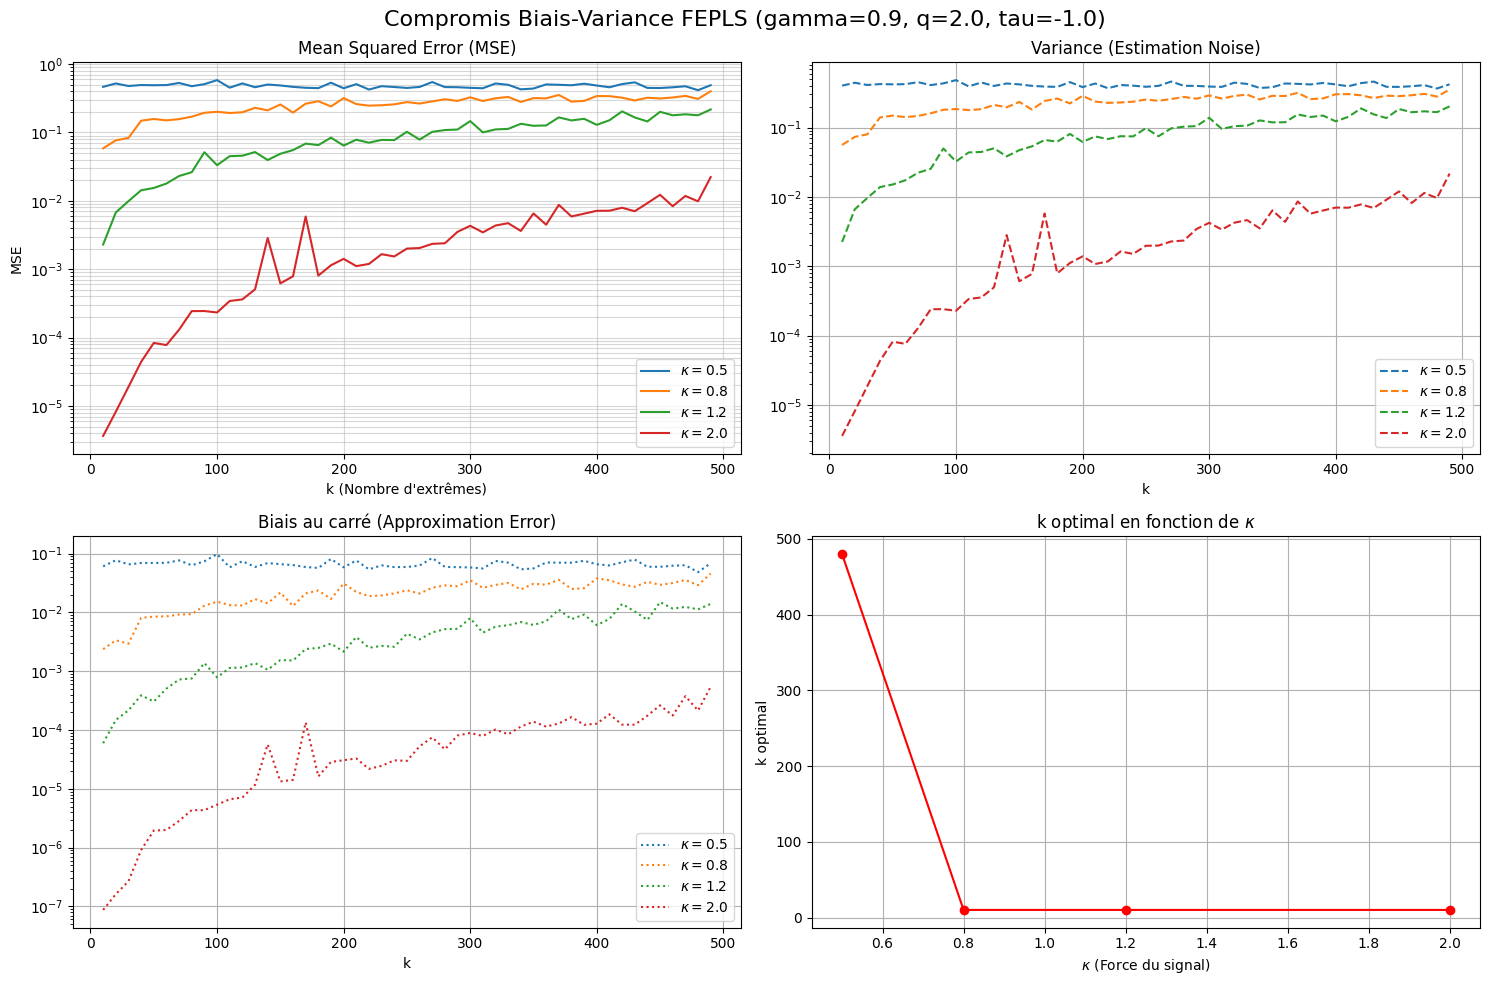

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. CONFIGURATION ET PARAMÈTRES FIXES (Comme demandé par ton binôme)  MDRRRRRRRRRRRRRRRR

GAMMA =1
Q = 2.0
N_SAMPLES = 500  # Nombre de points pour la simu
N_MC = 50  # Nombre de répétitions Monte-Carlo pour lisser les courbes
D = 50 # Dimension de X

# Vrai vecteur beta (direction cible)
TRUE_BETA = np.zeros(D)
TRUE_BETA[:5] = 1.0
TRUE_BETA = TRUE_BETA / np.linalg.norm(TRUE_BETA)

def generate_data(n, kappa, gamma, q):
    """
    Génère des données synthétiques selon le modèle Inverse Single-Index
    X = Y^kappa * beta + noise
    """
    # 1. Génération de Y (Loi de Pareto / Fréchet avec index gamma)
    # U ~ Uniform(0,1) -> Y = U^(-gamma)
    U = np.random.uniform(0, 1, n)
    Y = U**(-gamma)
    
    # 2. Génération du Bruit (Noise) avec integrabilité q
    # Le bruit doit avoir des queues moins lourdes que le signal si q*kappa*gamma > 1
    # On prend un bruit Student-t ou similaire pour respecter q
    Noise = np.random.standard_t(df=q+0.1, size=(n, D)) 
    
    # 3. Construction de X : Signal + Bruit
    # Le signal est modulé par g(Y) ~ Y^kappa
    signal_strength = Y[:, np.newaxis] ** kappa
    X = signal_strength * TRUE_BETA + Noise
    
    return X, Y

def fepls_estimator(X, Y, k, tau):
    """
    Calcule l'estimateur FEPLS beta_hat pour un k et tau donné.
    """
    n = len(Y)
    
    # 1. Seuil
    y_sorted = np.sort(Y)
    threshold = y_sorted[n-k]
    
    # 2. Indices extrêmes
    indices = np.where(Y >= threshold)[0]
    
    # 3. Poids w = Y^tau
    weights = Y[indices] ** tau
    
    # 4. Somme pondérée
    X_extreme = X[indices]
    # Broadcasting pour multiplier chaque ligne X_i par son poids w_i
    weighted_sum = np.sum(X_extreme * weights[:, np.newaxis], axis=0)
    
    # 5. Normalisation
    norm = np.linalg.norm(weighted_sum)
    if norm == 0:
        return np.zeros_like(weighted_sum)
    return weighted_sum / norm

# --- 2. LA BOUCLE DE SIMULATION (Le cœur du travail) ---

# On fait varier Kappa comme demandé
kappas_to_test = [0.5, 0.8, 1.2, 2.0] # Différentes forces de signal
tau_fixe = -1.0 # Une valeur "safe" pour tau

# Stockage des résultats
results = {}

print("Lancement des simulations...")
for kappa in kappas_to_test:
    print(f"Simulation pour kappa = {kappa}...")
    
    # Plage de k (nombre d'extrêmes) à tester
    k_values = range(10, 500, 10)
    
    bias_list = []
    variance_list = []
    mse_list = []
    
    for k in k_values:
        betas = []
        # Monte Carlo pour estimer Biais et Variance
        for _ in range(N_MC):
            X, Y = generate_data(N_SAMPLES, kappa, GAMMA, Q)
            beta_hat = fepls_estimator(X, Y, k, tau_fixe)
            betas.append(beta_hat)
        
        betas = np.array(betas)
        
        # Calcul Bias^2, Variance, MSE
        # Bias: distance entre la moyenne des estimateurs et le vrai beta
        mean_beta = np.mean(betas, axis=0)
        bias_sq = np.sum((mean_beta - TRUE_BETA)**2)
        
        # Variance: dispersion des estimateurs autour de leur moyenne
        variance = np.mean(np.sum((betas - mean_beta)**2, axis=1))
        
        # MSE = Bias^2 + Variance
        mse = bias_sq + variance
        
        bias_list.append(bias_sq)
        variance_list.append(variance)
        mse_list.append(mse)
        
    results[kappa] = {
        'k': list(k_values),
        'bias': bias_list,
        'variance': variance_list,
        'mse': mse_list
    }

# --- 3. PLOTS (Ce qu'il veut voir ce soir) MDRRRRRRRRRRR ---

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Compromis Biais-Variance FEPLS (gamma={GAMMA}, q={Q}, tau={tau_fixe})', fontsize=16)

# Plot 1: MSE vs k pour différents Kappa
ax = axes[0, 0]
for kappa, res in results.items():
    ax.plot(res['k'], res['mse'], label=f'$\kappa={kappa}$')
ax.set_title('Mean Squared Error (MSE)')
ax.set_xlabel('k (Nombre d\'extrêmes)')
ax.set_ylabel('MSE')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.5)

# Plot 2: Variance vs k
ax = axes[0, 1]
for kappa, res in results.items():
    ax.plot(res['k'], res['variance'], linestyle='--', label=f'$\kappa={kappa}$')
ax.set_title('Variance (Estimation Noise)')
ax.set_xlabel('k')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

# Plot 3: Biais vs k
ax = axes[1, 0]
for kappa, res in results.items():
    ax.plot(res['k'], res['bias'], linestyle=':', label=f'$\kappa={kappa}$')
ax.set_title('Biais au carré (Approximation Error)')
ax.set_xlabel('k')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

# Plot 4: k_optimal vs Kappa
ax = axes[1, 1]
k_opt_list = []
kappa_list_sorted = sorted(results.keys())
for kappa in kappa_list_sorted:
    # Trouver le k qui minimise la MSE
    res = results[kappa]
    idx_min = np.argmin(res['mse'])
    k_opt = res['k'][idx_min]
    k_opt_list.append(k_opt)

ax.plot(kappa_list_sorted, k_opt_list, marker='o', color='red')
ax.set_title('k optimal en fonction de $\kappa$')
ax.set_xlabel('$\kappa$ (Force du signal)')
ax.set_ylabel('k optimal')
ax.grid(True)

plt.tight_layout()
plt.show()

<>:205: SyntaxWarning: invalid escape sequence '\k'
<>:206: SyntaxWarning: invalid escape sequence '\k'
<>:205: SyntaxWarning: invalid escape sequence '\k'
<>:206: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_563121/1766862747.py:205: SyntaxWarning: invalid escape sequence '\k'
  ax_kopt.set_title("k optimal en fonction de $\kappa$ (best tau par $\kappa$)")
/tmp/ipykernel_563121/1766862747.py:206: SyntaxWarning: invalid escape sequence '\k'
  ax_kopt.set_xlabel("$\kappa$")


kappa grid: [0.51  0.615 0.719 0.824 0.929 1.034 1.138 1.243 1.348 1.453 1.557 1.662
 1.767 1.872 1.976 2.081 2.186 2.291 2.395 2.5  ]
Lancement des simulations (avec kappas et taus proches des inégalités)...
gamma=1.0, q=2.0
grille de kappa: [0.51       0.61473684 0.71947368 0.82421053 0.92894737 1.03368421
 1.13842105 1.24315789 1.34789474 1.45263158 1.55736842 1.66210526
 1.76684211 1.87157895 1.97631579 2.08105263 2.18578947 2.29052632
 2.39526316 2.5       ]

Simulation pour kappa = 0.510, taus = [-0.5  -0.38 -0.26 -0.14 -0.02]
  tau = -0.500
  tau = -0.380
  tau = -0.260
  tau = -0.140
  tau = -0.020

Simulation pour kappa = 0.615, taus = [-0.605 -0.485 -0.365 -0.245 -0.125]
  tau = -0.605
  tau = -0.485
  tau = -0.365
  tau = -0.245
  tau = -0.125

Simulation pour kappa = 0.719, taus = [-0.709 -0.589 -0.469 -0.349 -0.229]
  tau = -0.709
  tau = -0.589
  tau = -0.469
  tau = -0.349
  tau = -0.229

Simulation pour kappa = 0.824, taus = [-0.814 -0.694 -0.574 -0.454 -0.334]
  tau = 

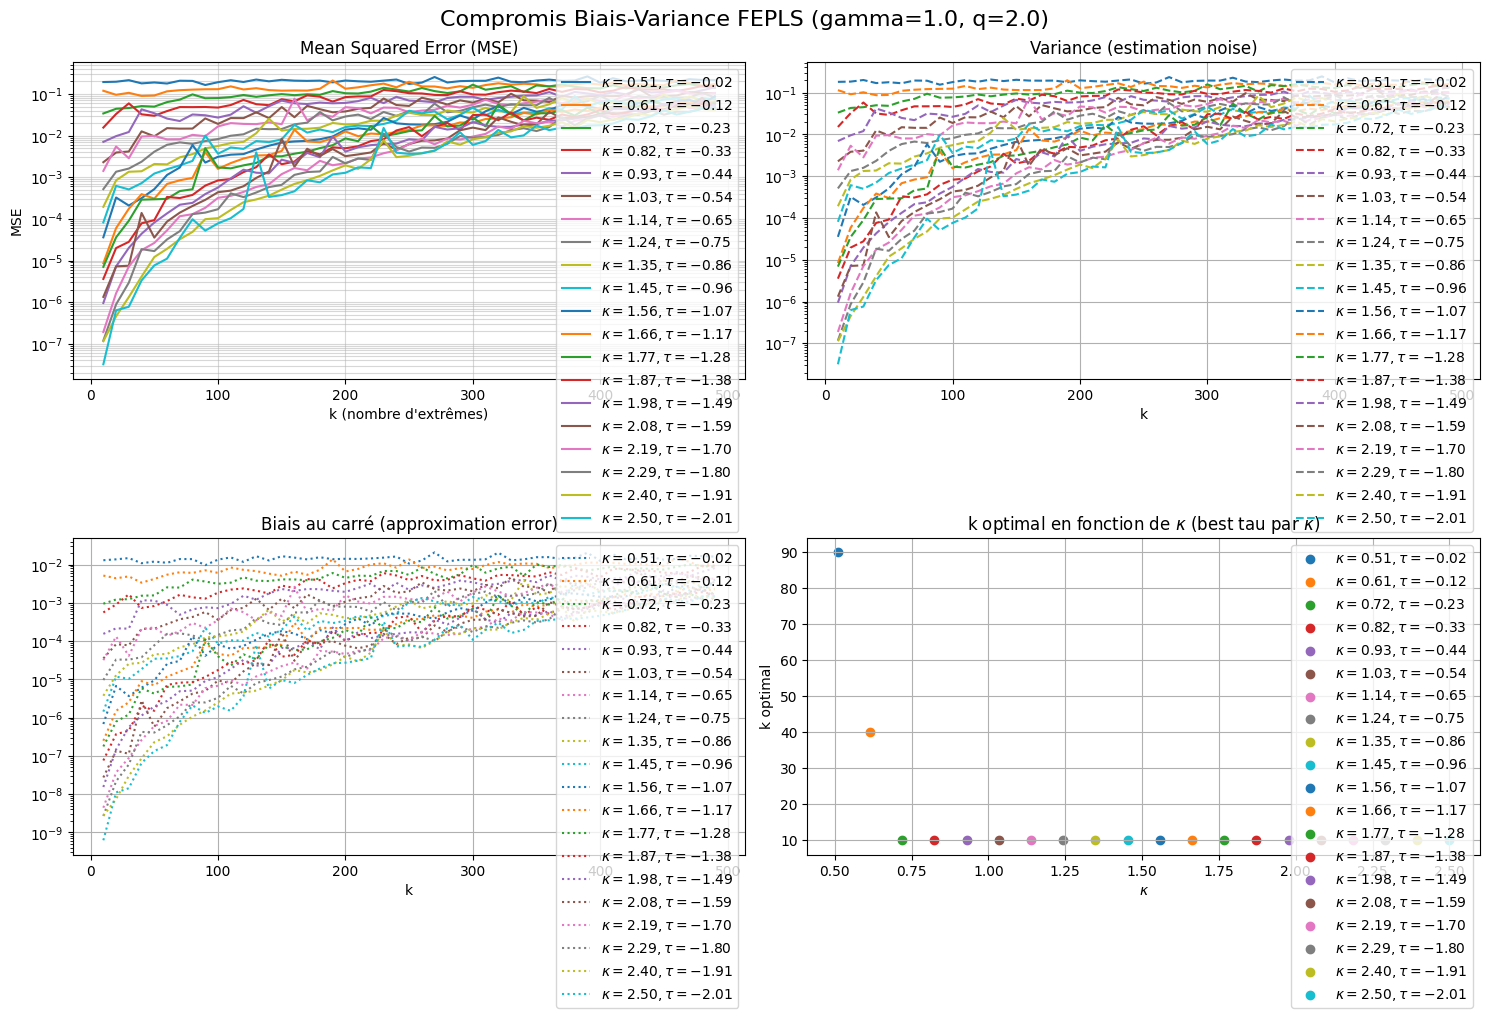

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. CONFIGURATION ET PARAMÈTRES FIXES

GAMMA = 1.0
Q = 2.0
N_SAMPLES = 500  # we set the sample size
N_MC = 50        # we set the number of Monte Carlo replications
D = 50           # we set the dimension of X

# vrai vecteur beta (direction cible)
TRUE_BETA = np.zeros(D)
TRUE_BETA[:5] = 1.0
TRUE_BETA = TRUE_BETA / np.linalg.norm(TRUE_BETA)

def generate_data(n, kappa, gamma, q):
    """
    we generate synthetic data according to the inverse single-index model
    X = Y^kappa * beta + noise
    """
    # 1. génération de Y (Pareto / Fréchet avec index gamma)
    U = np.random.uniform(0, 1, n)
    Y = U**(-gamma)

    # 2. bruit avec une intégrabilité q (ici t-distribution approchée)
    Noise = np.random.standard_t(df=q + 0.1, size=(n, D))

    # 3. construction de X : signal + bruit
    signal_strength = Y[:, np.newaxis] ** kappa
    X = signal_strength * TRUE_BETA + Noise
    return X, Y

def fepls_estimator(X, Y, k, tau):
    """
    we compute the FEPLS-style estimator beta_hat for a given k and tau
    """
    n = len(Y)

    # seuil
    y_sorted = np.sort(Y)
    threshold = y_sorted[n - k]

    # indices extrêmes
    indices = np.where(Y >= threshold)[0]

    # poids w = Y^tau
    weights = Y[indices] ** tau

    # somme pondérée
    X_extreme = X[indices]
    weighted_sum = np.sum(X_extreme * weights[:, np.newaxis], axis=0)

    # normalisation
    norm = np.linalg.norm(weighted_sum)
    if norm == 0:
        return np.zeros_like(weighted_sum)
    return weighted_sum / norm

def admissible_kappa_tau(gamma, q, kappa, tau):
    """
    we check the FEPLS inequalities:
      1) q * kappa * gamma > 1
      2) 0 < 2 * (kappa + tau) * gamma < 1
    """
    return (q * kappa * gamma > 1.0) and (0.0 < 2.0 * (kappa + tau) * gamma < 1.0)

def tau_grid_for_kappa(kappa, gamma, n_tau=5, eps=1e-2):
    """
    we build a small grid of tau values near the inequality bounds
      -kappa < tau < 1/(2*gamma) - kappa
    and we stay epsilon inside the interval
    """
    tau_lower = -kappa + eps
    tau_upper = (1.0 / (2.0 * gamma)) - kappa - eps
    if tau_lower >= tau_upper:
        return []
    return np.linspace(tau_lower, tau_upper, n_tau)

# --- 2. BOUCLE DE SIMULATION AVEC KAPPA, TAU PRÈS DES BORNES

# we choose kappas near the lower bound kappa > 1 / (Q * GAMMA)
eps_kappa = 1e-2  # we stay slightly inside q*kappa*gamma > 1
kappa_min = 1.0 / (Q * GAMMA) + eps_kappa
kappa_max = 2.5                     # you can adjust the upper bound if needed
N_KAPPA  = 20                       # we choose about twenty kappa values

kappas_to_test = np.linspace(kappa_min, kappa_max, N_KAPPA)
print("kappa grid:", np.round(kappas_to_test, 3))
# plage de k (nombre d'extrêmes) à tester
k_values = range(10, 500, 10)

# stockage des résultats: results[kappa][tau] = {...}
results = {}

print("Lancement des simulations (avec kappas et taus proches des inégalités)...")
print(f"gamma={GAMMA}, q={Q}")
print(f"grille de kappa: {kappas_to_test}")

for kappa in kappas_to_test:
    # we build tau values for this kappa near the inequality bounds
    tau_values = tau_grid_for_kappa(kappa, GAMMA, n_tau=5, eps=1e-2)
    # we keep only admissible (kappa, tau)
    tau_values = [tau for tau in tau_values if admissible_kappa_tau(GAMMA, Q, kappa, tau)]

    if len(tau_values) == 0:
        print(f"kappa={kappa:.3f}: aucune valeur de tau admissible, on saute.")
        continue

    print(f"\nSimulation pour kappa = {kappa:.3f}, taus = {np.round(tau_values, 3)}")
    results[kappa] = {}

    for tau_fixe in tau_values:
        print(f"  tau = {tau_fixe:.3f}")
        bias_list = []
        variance_list = []
        mse_list = []

        for k in k_values:
            betas = []

            # Monte Carlo pour estimer biais et variance
            for _ in range(N_MC):
                X, Y = generate_data(N_SAMPLES, kappa, GAMMA, Q)
                beta_hat = fepls_estimator(X, Y, k, tau_fixe)
                betas.append(beta_hat)

            betas = np.array(betas)

            # biais^2
            mean_beta = np.mean(betas, axis=0)
            bias_sq = np.sum((mean_beta - TRUE_BETA) ** 2)

            # variance
            variance = np.mean(np.sum((betas - mean_beta) ** 2, axis=1))

            # MSE = biais^2 + variance
            mse = bias_sq + variance

            bias_list.append(bias_sq)
            variance_list.append(variance)
            mse_list.append(mse)

        results[kappa][tau_fixe] = {
            "k": list(k_values),
            "bias": bias_list,
            "variance": variance_list,
            "mse": mse_list,
        }

# --- 3. PLOTS SIMPLES (ON FIXE UN TAU PAR KAPPA POUR ILLUSTRER)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax_mse, ax_var, ax_bias, ax_kopt = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

fig.suptitle(f'Compromis Biais-Variance FEPLS (gamma={GAMMA}, q={Q})', fontsize=16)

# we choose, for chaque kappa, le tau avec la plus petite MSE moyenne
for kappa in sorted(results.keys()):
    tau_candidates = list(results[kappa].keys())
    avg_mse_per_tau = []
    for tau in tau_candidates:
        avg_mse = np.mean(results[kappa][tau]["mse"])
        avg_mse_per_tau.append(avg_mse)
    best_tau = tau_candidates[int(np.argmin(avg_mse_per_tau))]

    res = results[kappa][best_tau]
    label = rf'$\kappa={kappa:.2f}, \tau={best_tau:.2f}$'

    # MSE vs k
    ax_mse.plot(res["k"], res["mse"], label=label)

    # variance vs k
    ax_var.plot(res["k"], res["variance"], linestyle="--", label=label)

    # biais^2 vs k
    ax_bias.plot(res["k"], res["bias"], linestyle=":", label=label)

    # k_opt pour ce couple (kappa, best_tau)
    idx_min = int(np.argmin(res["mse"]))
    k_opt = res["k"][idx_min]
    ax_kopt.scatter(kappa, k_opt, label=label)

# mise en forme des axes
ax_mse.set_title("Mean Squared Error (MSE)")
ax_mse.set_xlabel("k (nombre d'extrêmes)")
ax_mse.set_ylabel("MSE")
ax_mse.set_yscale("log")
ax_mse.grid(True, which="both", ls="-", alpha=0.5)
ax_mse.legend()

ax_var.set_title("Variance (estimation noise)")
ax_var.set_xlabel("k")
ax_var.set_yscale("log")
ax_var.grid(True)
ax_var.legend()

ax_bias.set_title("Biais au carré (approximation error)")
ax_bias.set_xlabel("k")
ax_bias.set_yscale("log")
ax_bias.grid(True)
ax_bias.legend()

ax_kopt.set_title("k optimal en fonction de $\kappa$ (best tau par $\kappa$)")
ax_kopt.set_xlabel("$\kappa$")
ax_kopt.set_ylabel("k optimal")
ax_kopt.grid(True)
ax_kopt.legend()

plt.tight_layout()
plt.show()

<>:205: SyntaxWarning: invalid escape sequence '\k'
<>:206: SyntaxWarning: invalid escape sequence '\k'
<>:205: SyntaxWarning: invalid escape sequence '\k'
<>:206: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_563121/1071469689.py:205: SyntaxWarning: invalid escape sequence '\k'
  ax_kopt.set_title("k optimal en fonction de $\kappa$ (best tau par $\kappa$)")
/tmp/ipykernel_563121/1071469689.py:206: SyntaxWarning: invalid escape sequence '\k'
  ax_kopt.set_xlabel("$\kappa$")


kappa grid: [0.51  0.523 0.535 0.548 0.561 0.573 0.586 0.598 0.611 0.624 0.636 0.649
 0.662 0.674 0.687 0.699 0.712 0.725 0.737 0.75 ]
Lancement des simulations (avec kappas et taus proches des inégalités)...
gamma=1.0, q=2.0
grille de kappa: [0.51       0.52263158 0.53526316 0.54789474 0.56052632 0.57315789
 0.58578947 0.59842105 0.61105263 0.62368421 0.63631579 0.64894737
 0.66157895 0.67421053 0.68684211 0.69947368 0.71210526 0.72473684
 0.73736842 0.75      ]

Simulation pour kappa = 0.510, taus = [-0.5  -0.38 -0.26 -0.14 -0.02]
  tau = -0.500
  tau = -0.380
  tau = -0.260
  tau = -0.140
  tau = -0.020

Simulation pour kappa = 0.523, taus = [-0.513 -0.393 -0.273 -0.153 -0.033]
  tau = -0.513
  tau = -0.393
  tau = -0.273
  tau = -0.153
  tau = -0.033

Simulation pour kappa = 0.535, taus = [-0.525 -0.405 -0.285 -0.165 -0.045]
  tau = -0.525
  tau = -0.405
  tau = -0.285
  tau = -0.165
  tau = -0.045

Simulation pour kappa = 0.548, taus = [-0.538 -0.418 -0.298 -0.178 -0.058]
  tau = 

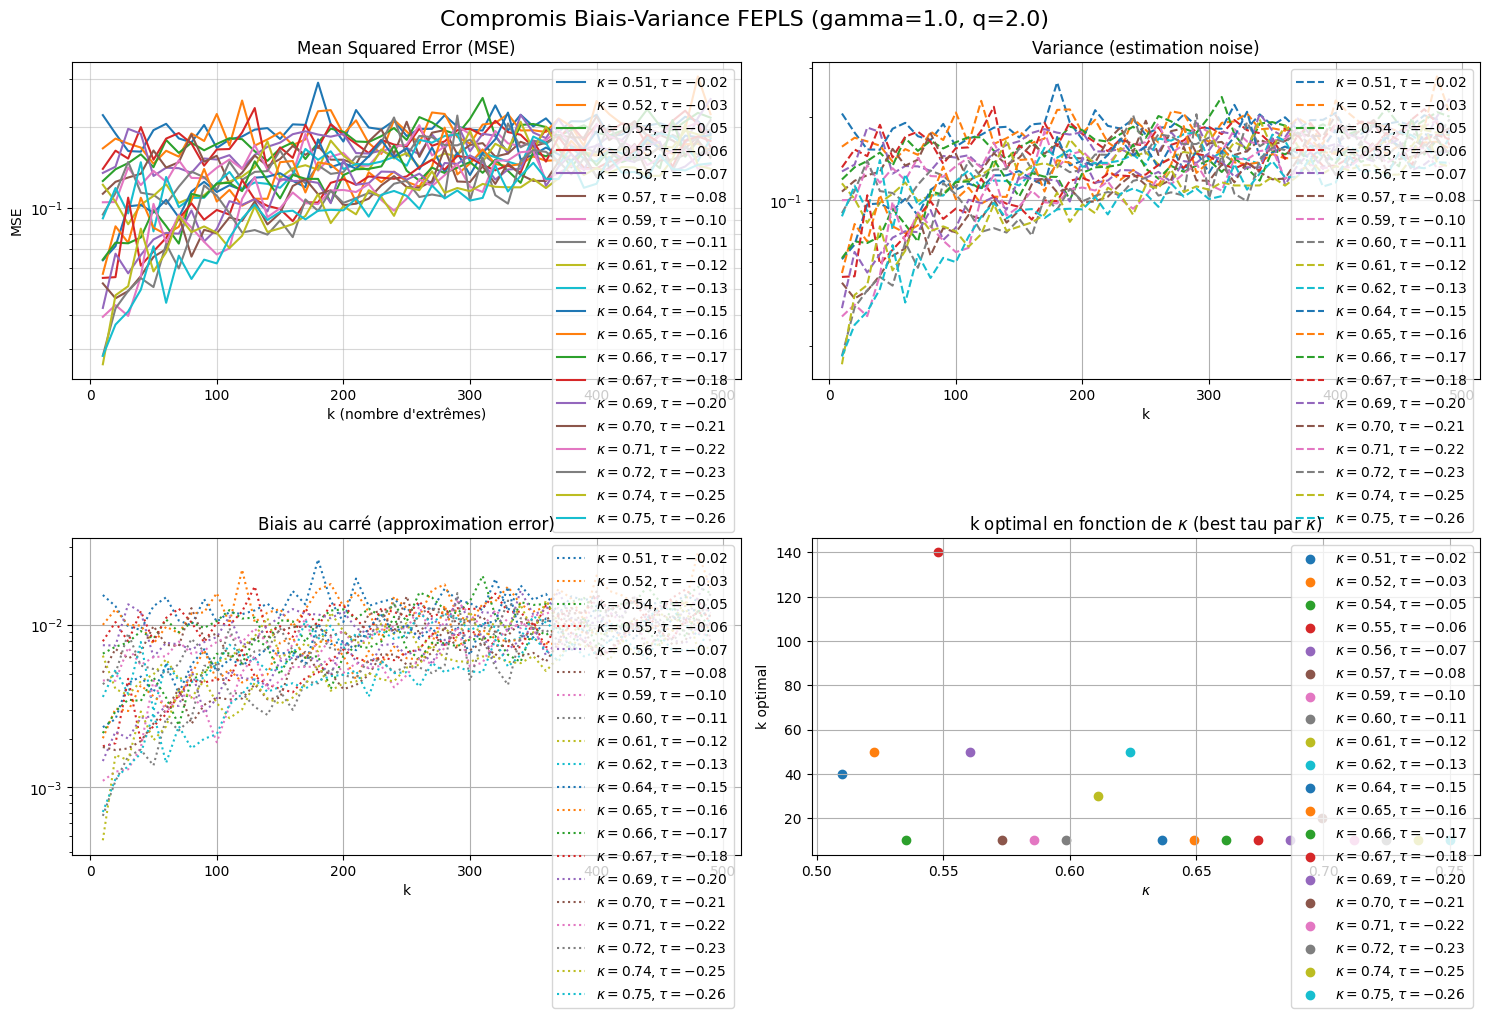

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. CONFIGURATION ET PARAMÈTRES FIXES

GAMMA = 1.0
Q = 2.0
N_SAMPLES = 500  # we set the sample size
N_MC = 50        # we set the number of Monte Carlo replications
D = 50           # we set the dimension of X

# vrai vecteur beta (direction cible)
TRUE_BETA = np.zeros(D)
TRUE_BETA[:5] = 1.0
TRUE_BETA = TRUE_BETA / np.linalg.norm(TRUE_BETA)

def generate_data(n, kappa, gamma, q):
    """
    we generate synthetic data according to the inverse single-index model
    X = Y^kappa * beta + noise
    """
    # 1. génération de Y (Pareto / Fréchet avec index gamma)
    U = np.random.uniform(0, 1, n)
    Y = U**(-gamma)

    # 2. bruit avec une intégrabilité q (ici t-distribution approchée)
    Noise = np.random.standard_t(df=q + 0.1, size=(n, D))

    # 3. construction de X : signal + bruit
    signal_strength = Y[:, np.newaxis] ** kappa
    X = signal_strength * TRUE_BETA + Noise
    return X, Y

def fepls_estimator(X, Y, k, tau):
    """
    we compute the FEPLS-style estimator beta_hat for a given k and tau
    """
    n = len(Y)

    # seuil
    y_sorted = np.sort(Y)
    threshold = y_sorted[n - k]

    # indices extrêmes
    indices = np.where(Y >= threshold)[0]

    # poids w = Y^tau
    weights = Y[indices] ** tau

    # somme pondérée
    X_extreme = X[indices]
    weighted_sum = np.sum(X_extreme * weights[:, np.newaxis], axis=0)

    # normalisation
    norm = np.linalg.norm(weighted_sum)
    if norm == 0:
        return np.zeros_like(weighted_sum)
    return weighted_sum / norm

def admissible_kappa_tau(gamma, q, kappa, tau):
    """
    we check the FEPLS inequalities:
      1) q * kappa * gamma > 1
      2) 0 < 2 * (kappa + tau) * gamma < 1
    """
    return (q * kappa * gamma > 1.0) and (0.0 < 2.0 * (kappa + tau) * gamma < 1.0)

def tau_grid_for_kappa(kappa, gamma, n_tau=5, eps=1e-2):
    """
    we build a small grid of tau values near the inequality bounds
      -kappa < tau < 1/(2*gamma) - kappa
    and we stay epsilon inside the interval
    """
    tau_lower = -kappa + eps
    tau_upper = (1.0 / (2.0 * gamma)) - kappa - eps
    if tau_lower >= tau_upper:
        return []
    return np.linspace(tau_lower, tau_upper, n_tau)

# --- 2. BOUCLE DE SIMULATION AVEC KAPPA, TAU PRÈS DES BORNES

# we choose kappas near the lower bound kappa > 1 / (Q * GAMMA)
eps_kappa = 1e-2  # we stay slightly inside q*kappa*gamma > 1
kappa_min = 1.0 / (Q * GAMMA) + eps_kappa
kappa_max = 0.75                     # you can adjust the upper bound if needed
N_KAPPA  = 20                       # we choose about twenty kappa values

kappas_to_test = np.linspace(kappa_min, kappa_max, N_KAPPA)
print("kappa grid:", np.round(kappas_to_test, 3))
# plage de k (nombre d'extrêmes) à tester
k_values = range(10, 500, 10)

# stockage des résultats: results[kappa][tau] = {...}
results = {}

print("Lancement des simulations (avec kappas et taus proches des inégalités)...")
print(f"gamma={GAMMA}, q={Q}")
print(f"grille de kappa: {kappas_to_test}")

for kappa in kappas_to_test:
    # we build tau values for this kappa near the inequality bounds
    tau_values = tau_grid_for_kappa(kappa, GAMMA, n_tau=5, eps=1e-2)
    # we keep only admissible (kappa, tau)
    tau_values = [tau for tau in tau_values if admissible_kappa_tau(GAMMA, Q, kappa, tau)]

    if len(tau_values) == 0:
        print(f"kappa={kappa:.3f}: aucune valeur de tau admissible, on saute.")
        continue

    print(f"\nSimulation pour kappa = {kappa:.3f}, taus = {np.round(tau_values, 3)}")
    results[kappa] = {}

    for tau_fixe in tau_values:
        print(f"  tau = {tau_fixe:.3f}")
        bias_list = []
        variance_list = []
        mse_list = []

        for k in k_values:
            betas = []

            # Monte Carlo pour estimer biais et variance
            for _ in range(N_MC):
                X, Y = generate_data(N_SAMPLES, kappa, GAMMA, Q)
                beta_hat = fepls_estimator(X, Y, k, tau_fixe)
                betas.append(beta_hat)

            betas = np.array(betas)

            # biais^2
            mean_beta = np.mean(betas, axis=0)
            bias_sq = np.sum((mean_beta - TRUE_BETA) ** 2)

            # variance
            variance = np.mean(np.sum((betas - mean_beta) ** 2, axis=1))

            # MSE = biais^2 + variance
            mse = bias_sq + variance

            bias_list.append(bias_sq)
            variance_list.append(variance)
            mse_list.append(mse)

        results[kappa][tau_fixe] = {
            "k": list(k_values),
            "bias": bias_list,
            "variance": variance_list,
            "mse": mse_list,
        }

# --- 3. PLOTS SIMPLES (ON FIXE UN TAU PAR KAPPA POUR ILLUSTRER)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax_mse, ax_var, ax_bias, ax_kopt = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

fig.suptitle(f'Compromis Biais-Variance FEPLS (gamma={GAMMA}, q={Q})', fontsize=16)

# we choose, for chaque kappa, le tau avec la plus petite MSE moyenne
for kappa in sorted(results.keys()):
    tau_candidates = list(results[kappa].keys())
    avg_mse_per_tau = []
    for tau in tau_candidates:
        avg_mse = np.mean(results[kappa][tau]["mse"])
        avg_mse_per_tau.append(avg_mse)
    best_tau = tau_candidates[int(np.argmin(avg_mse_per_tau))]

    res = results[kappa][best_tau]
    label = rf'$\kappa={kappa:.2f}, \tau={best_tau:.2f}$'

    # MSE vs k
    ax_mse.plot(res["k"], res["mse"], label=label)

    # variance vs k
    ax_var.plot(res["k"], res["variance"], linestyle="--", label=label)

    # biais^2 vs k
    ax_bias.plot(res["k"], res["bias"], linestyle=":", label=label)

    # k_opt pour ce couple (kappa, best_tau)
    idx_min = int(np.argmin(res["mse"]))
    k_opt = res["k"][idx_min]
    ax_kopt.scatter(kappa, k_opt, label=label)

# mise en forme des axes
ax_mse.set_title("Mean Squared Error (MSE)")
ax_mse.set_xlabel("k (nombre d'extrêmes)")
ax_mse.set_ylabel("MSE")
ax_mse.set_yscale("log")
ax_mse.grid(True, which="both", ls="-", alpha=0.5)
ax_mse.legend()

ax_var.set_title("Variance (estimation noise)")
ax_var.set_xlabel("k")
ax_var.set_yscale("log")
ax_var.grid(True)
ax_var.legend()

ax_bias.set_title("Biais au carré (approximation error)")
ax_bias.set_xlabel("k")
ax_bias.set_yscale("log")
ax_bias.grid(True)
ax_bias.legend()

ax_kopt.set_title("k optimal en fonction de $\kappa$ (best tau par $\kappa$)")
ax_kopt.set_xlabel("$\kappa$")
ax_kopt.set_ylabel("k optimal")
ax_kopt.grid(True)
ax_kopt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os

def generate_data(n_samples=1000, n_features=101, rho_values=[-1, -2, -5]):
    """
    Génère et sauvegarde les données (Y, X) pour différentes valeurs de rho.
    Fixe gamma=1 et q=2 selon la stratégie d'optimisation.
    """
    # Paramètres fixes
    gamma = 0.9 
    
    # Grille fonctionnelle t dans [0, 1]
    t = np.linspace(0, 1, n_features)
    
    # [cite_start]La vraie direction beta (sinus comme dans le papier [cite: 211])
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta) # Normalisation

    data_store = {}

    print(f"Génération pour gamma={gamma} (fixé)...")

    for rho in rho_values:
        print(f"  -> Génération pour rho = {rho}")
        
        # [cite_start]1. Simulation de Y (Loi de Burr) [cite: 208]
        # F_bar(y) = (1 + y^(-rho/gamma))^(1/rho)
        # Inverse pour simulation: U ~ Uniform(0,1)
        U = np.random.rand(n_samples)
        Y = ((U**rho - 1)**(-gamma/rho))
        
        # 2. Simulation du Bruit Epsilon (Fonctionnel)
        # Bruit gaussien centré simple ("flemme" sur le bruit)
        # On s'assure juste que E[||epsilon||^q] < infini (q=2 ici)
        noise = np.random.normal(0, 0.5, size=(n_samples, n_features))
        
        # NOTE: X est construit plus tard dans la simulation car il dépend de g(Y) (donc de kappa).
        # On sauvegarde Y et le Bruit séparément pour pouvoir changer kappa à la volée.
        
        data_store[rho] = {
            'Y': Y,
            'noise': noise,
            'true_beta': true_beta,
            't': t,
            'gamma': gamma
        }

    # Sauvegarde dans un fichier compressé
    np.savez('simulated_data.npz', data_store=data_store)
    print("Données sauvegardées dans 'simulated_data.npz'")

if __name__ == "__main__":
    generate_data(n_samples=2000, rho_values=[-0.5, -1.0, -2.0])

Génération pour gamma=1.0 (fixé)...
  -> Génération pour rho = -0.5
  -> Génération pour rho = -1.0
  -> Génération pour rho = -2.0
Données sauvegardées dans 'simulated_data.npz'


Lancement simulation (rho=-1.0)...


<>:144: SyntaxWarning: invalid escape sequence '\k'
<>:160: SyntaxWarning: invalid escape sequence '\k'
<>:175: SyntaxWarning: invalid escape sequence '\k'
<>:177: SyntaxWarning: invalid escape sequence '\k'
<>:203: SyntaxWarning: invalid escape sequence '\k'
<>:204: SyntaxWarning: invalid escape sequence '\k'
<>:144: SyntaxWarning: invalid escape sequence '\k'
<>:160: SyntaxWarning: invalid escape sequence '\k'
<>:175: SyntaxWarning: invalid escape sequence '\k'
<>:177: SyntaxWarning: invalid escape sequence '\k'
<>:203: SyntaxWarning: invalid escape sequence '\k'
<>:204: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_563121/3109583209.py:144: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['mse'], label=f"$\kappa={kappa}$", linewidth=2)
/tmp/ipykernel_563121/3109583209.py:160: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f"Décomposition Biais-Variance ($\kappa={params_demo[0]}, \\tau={params_demo[1]}$)")
/tmp/ipykernel_563121/3109583209.p

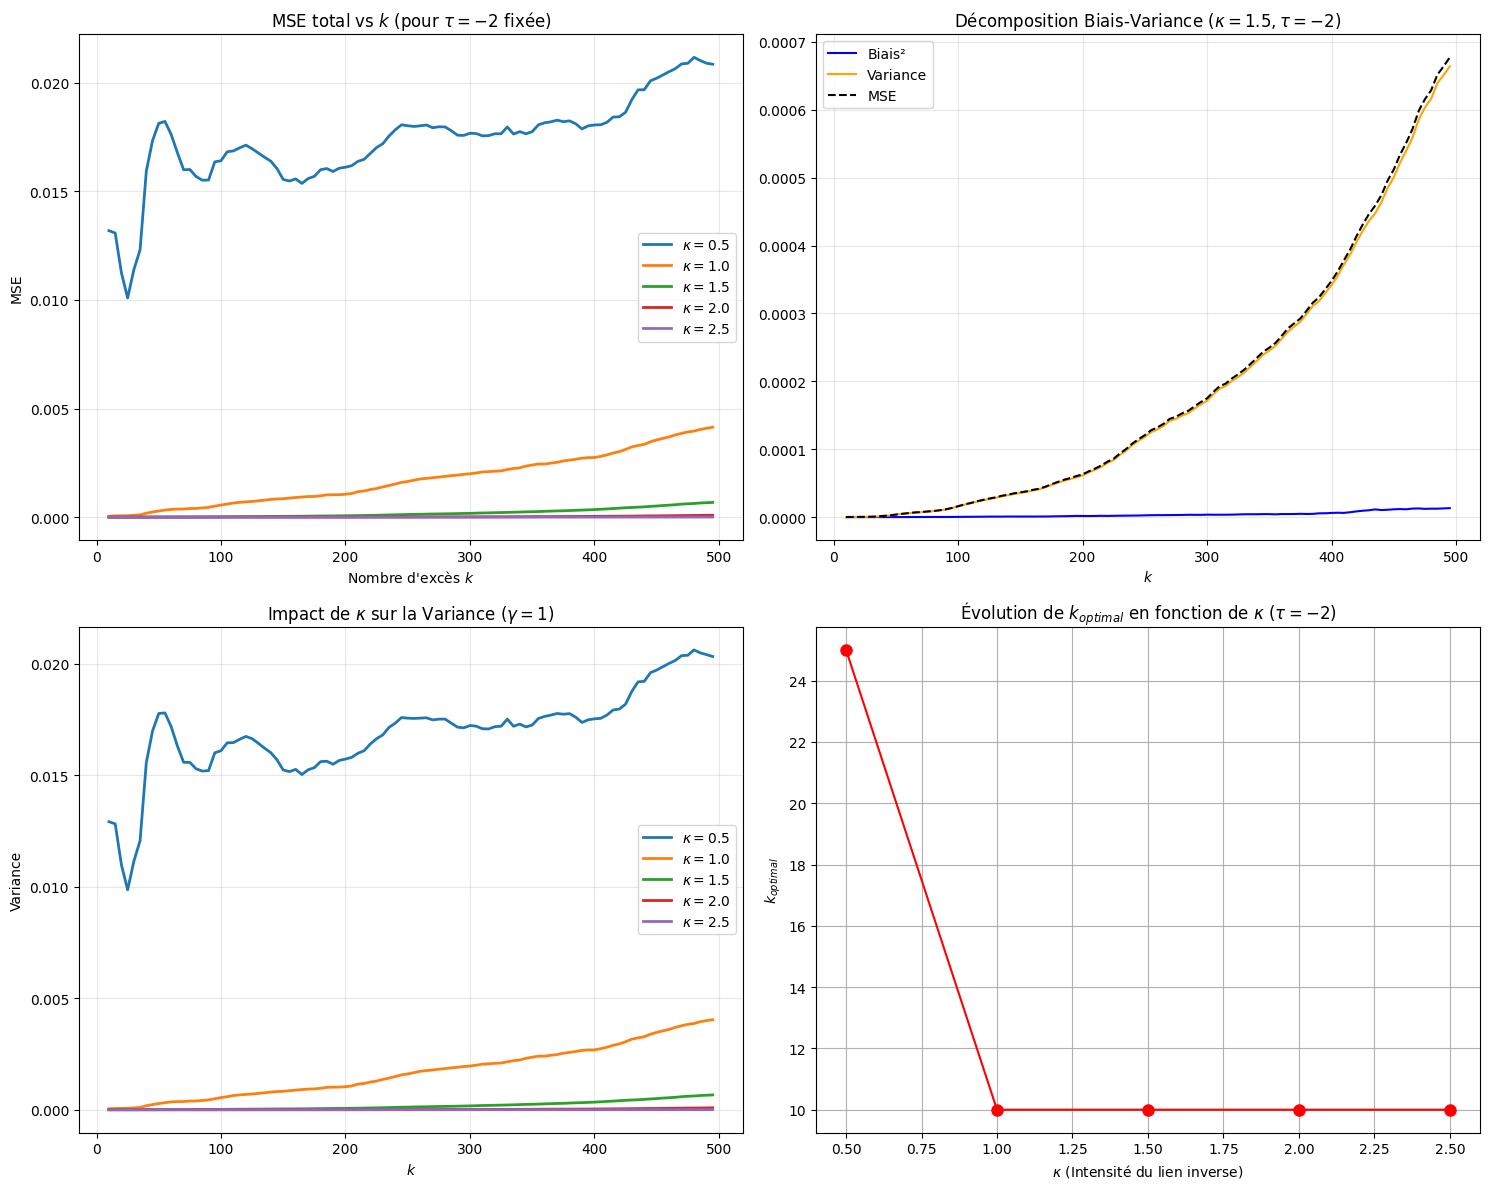

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- 1. Fonctions Utilitaires ---

def load_data(filename='simulated_data.npz'):
    loaded = np.load(filename, allow_pickle=True)
    return loaded['data_store'].item()

def get_fepls_estimator(X, Y, k, tau):
    """
    Calcule l'estimateur beta_phi pour un seuil k donné.
    [cite_start]Formule basée sur les moments de queue empiriques[cite: 161].
    """
    n = len(Y)
    # Seuil aléatoire Y_{n-k+1, n}
    threshold_idx = np.argsort(Y)[n-k]
    threshold_val = Y[threshold_idx]
    
    # Indices des excès
    indices = np.where(Y >= threshold_val)[0]
    
    if len(indices) == 0:
        return np.zeros(X.shape[1])
    
    # [cite_start]Test function phi(y) = y^tau [cite: 218]
    phi_Y = Y[indices] ** tau
    
    # [cite_start]Calcul de v_hat [cite: 161]
    # v_hat = mean(X * phi(Y) * 1_{Y>y})
    X_tail = X[indices]
    
    # Produit tensoriel pour pondérer chaque courbe X_i par phi(Y_i)
    # X_tail est (k, d), phi_Y est (k,)
    weighted_sum = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0)
    v_hat = weighted_sum / n
    
    # Normalisation pour obtenir beta_hat
    norm_v = np.linalg.norm(v_hat)
    if norm_v > 0:
        return v_hat / norm_v
    else:
        return v_hat

# --- 2. Moteur de Simulation ---

def run_simulation_grid(rho_key=-1.0, kappa_list=[0.6, 1.0, 1.5, 2.0], tau_list=[-0.5, -2]):
    """
    Explore l'espace des paramètres kappa/tau.
    """
    data_pack = load_data()
    data = data_pack[rho_key]
    
    Y_raw = data['Y']
    noise = data['noise']
    true_beta = data['true_beta']
    gamma = data['gamma'] # Fixé à 1
    
    # Paramètres de simulation
    n = len(Y_raw)
    k_range = np.arange(10, n // 4, 5) # On regarde les k "raisonnables"
    results = {}

    print(f"Lancement simulation (rho={rho_key})...")
    
    for kappa in kappa_list:
        # [cite_start]Construction de X selon le modèle X = g(Y)beta + noise [cite: 145]
        # [cite_start]g(y) = y^kappa [cite: 211]
        g_Y = Y_raw[:, np.newaxis] ** kappa
        X = g_Y * true_beta + noise
        
        for tau in tau_list:
            # [cite_start]Vérification des inégalités théoriques pour info [cite: 167, 168]
            # Condition: 0 < 2(kappa + tau)gamma < 1  (avec gamma=1)
            cond_exist = 0 < 2 * (kappa + tau) < 1
            cond_noise = 2 * kappa > 1 # car q=2
            
            label = f"k={kappa}, t={tau} | Valid: {cond_exist and cond_noise}"
            
            bias2_list = []
            var_list = []
            mse_list = []
            
            # Monte Carlo "Bootstrap" rapide (ou juste sur le k)
            # Pour estimer la variance, on divise le dataset en N sous-échantillons ou on répète
            # Ici pour l'exemple, on calcule l'erreur quadratique simple sur une itération
            # (Pour une vraie variance, il faudrait régénérer le bruit plusieurs fois, 
            #  mais le script data_gen est statique. On suppose ici ergodicité ou on simplifie).
            
            # NOTE: Pour avoir Bias/Var séparés correctement, il faut plusieurs tirages.
            # On va simuler artificiellement des tirages en ajoutant du bruit au X existant
            n_mc = 50 
            betas_k = np.zeros((len(k_range), n_mc, len(true_beta)))
            
            for i_mc in range(n_mc):
                # On recrée un bruit aléatoire pour le MC
                current_noise = np.random.normal(0, 0.5, size=X.shape)
                X_mc = g_Y * true_beta + current_noise
                
                for idx_k, k in enumerate(k_range):
                    est_beta = get_fepls_estimator(X_mc, Y_raw, k, tau)
                    
                    # Alignement de signe (le vecteur propre est défini au signe près)
                    if np.dot(est_beta, true_beta) < 0:
                        est_beta = -est_beta
                    
                    betas_k[idx_k, i_mc, :] = est_beta

            # Calcul des métriques agrégées
            # Bias^2 = || Mean(Beta_hat) - Beta_true ||^2
            mean_betas = np.mean(betas_k, axis=1) # (len(k), d)
            bias2 = np.sum((mean_betas - true_beta)**2, axis=1)
            
            # Variance = Mean( || Beta_hat - Mean(Beta_hat) ||^2 )
            # Calcul trace de la covariance ou somme des variances par point
            var = np.mean(np.sum((betas_k - mean_betas[:, np.newaxis, :])**2, axis=2), axis=1)
            
            mse = bias2 + var
            
            results[(kappa, tau)] = {
                'k': k_range,
                'bias2': bias2,
                'var': var,
                'mse': mse,
                'label': label
            }
            
    return results

# --- 3. Plotting Avancé ---

def plot_results(results):
    """
    Génère les plots demandés : Biais, Variance, MSE, et Impact de Kappa.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: MSE global (Dilemme Biais-Variance classique)
    ax = axes[0, 0]
    for params, res in results.items():
        kappa, tau = params
        if tau == -2: # On fixe un tau pour voir l'effet de kappa
            ax.plot(res['k'], res['mse'], label=f"$\kappa={kappa}$", linewidth=2)
    ax.set_title("MSE total vs $k$ (pour $\\tau=-2$ fixée)")
    ax.set_xlabel("Nombre d'excès $k$")
    ax.set_ylabel("MSE")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Décomposition Biais-Variance pour un cas spécifique
    # On prend le cas le plus "standard" (ex: kappa=1.5, tau=-2)
    ax = axes[0, 1]
    params_demo = (1.5, -2)
    if params_demo in results:
        res = results[params_demo]
        ax.plot(res['k'], res['bias2'], label="Biais²", color='blue')
        ax.plot(res['k'], res['var'], label="Variance", color='orange')
        ax.plot(res['k'], res['mse'], label="MSE", color='black', linestyle='--')
        ax.set_title(f"Décomposition Biais-Variance ($\kappa={params_demo[0]}, \\tau={params_demo[1]}$)")
    else:
        ax.text(0.5, 0.5, "Paramètres démo non trouvés", ha='center')
    ax.set_xlabel("$k$")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Impact de Kappa sur la Variance (Hypothèse WhatsApp)
    # "kappa grand induit qu'il y a davantage de points extrêmes à prendre ce qui diminue la variance"
    ax = axes[1, 0]
    colors = cm.viridis(np.linspace(0, 1, len(results)))
    i = 0
    for params, res in results.items():
        kappa, tau = params
        if tau == -2: # On compare à tau constant
            ax.plot(res['k'], res['var'], label=f"$\kappa={kappa}$", linewidth=2)
    
    ax.set_title("Impact de $\kappa$ sur la Variance ($\gamma=1$)")
    ax.set_xlabel("$k$")
    ax.set_ylabel("Variance")
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Interprétation attendue: Plus kappa est grand, plus la courbe devrait être basse ou stable
    
    # Plot 4: k_optimal en fonction de kappa
    ax = axes[1, 1]
    kappas = []
    k_opts = []
    
    # On filtre pour un tau donné
    target_tau = -2
    sorted_items = sorted([item for item in results.items() if item[0][1] == target_tau])
    
    for params, res in sorted_items:
        kappa = params[0]
        # k optimal est celui qui minimise la MSE
        idx_min = np.argmin(res['mse'])
        k_opt = res['k'][idx_min]
        
        kappas.append(kappa)
        k_opts.append(k_opt)
        
    ax.plot(kappas, k_opts, 'o-', color='red', markersize=8)
    ax.set_title(f"Évolution de $k_{{optimal}}$ en fonction de $\kappa$ ($\\tau={target_tau}$)")
    ax.set_xlabel("$\kappa$ (Intensité du lien inverse)")
    ax.set_ylabel("$k_{optimal}$")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Exécution de l'analyse sur rho=-1.0 (cas standard)
    # On teste les limites des inégalités: 
    # Inégalité stricte: 2(kappa+tau) < 1. 
    # Avec tau=-2, kappa peut aller jusqu'à 2.5
    results = run_simulation_grid(
        rho_key=-1.0, 
        kappa_list=[0.5, 1.0, 1.5, 2.0, 2.5], 
        tau_list=[-2] 
    )
    plot_results(results)